# Indexing

In this part of the project, we address the challenge of retrieving the most relevant documents based on a user's query. Our goal is to compare the effectiveness of different retrieval models on a real-world dataset of recipes.

Given the large number of documents, we adopted a two-stage retrieval strategy: In the first stage, we use either TF-IDF or KNN over embeddings to retrieve the top 50 candidate documents for each query. In the second stage, we apply cosine similarity and a cross-encoder model to re-rank these candidates, aiming to improve the quality and relevance of the final ranking.

A key challenge lies in the evaluation process, which is non-trivial due to the absence of a standard test set. 
To overcome this, we:

- Collected the top 50 results from both TF-IDF and KNN-based methods.

- Used a Large Language Model (LLM) and a human-in-the-loop strategy to curate a reference ranking.

- Investigated evaluation metrics, focusing on rank-based measures to quantify consistency with the reference.

## Loading

In [ ]:
df=pd.read_csv(f"./full_dataset.csv")
df=df[["title","ingredients","directions","NER"]]

## Analysis

In [ ]:
documents = [
    [
        f"d{idx+1}",
        f"{sample['title']}  --  {clean_string(sample['ingredients'])} -- {clean_string(sample['directions'])}".strip()
    ]
    for idx, sample in df.iterrows()
]


docs_df = pd.DataFrame(documents, columns=["docno", "text"])

## First Indexing

### Creating Indexing

In [ ]:
indexer = pt.DFIndexer("./index_3docs", overwrite=True)
index_ref = indexer.index(docs_df["text"], docs_df["docno"])
index_ref.toString()
index = pt.IndexFactory.of(index_ref)

In [ ]:
import hnswlib

# Create empty index
hnswlib_index = hnswlib.Index(space='cosine', dim=corpus_embeddings.size(1))

# Define hnswlib index path
index_path = "./emp_dialogue_hnswlib.index"

# Load index if available
if os.path.exists(index_path):
    print("Loading index...")
    hnswlib_index.load_index(index_path)
# Else index data collection
else:
    # Initialise the index
    print("Start creating HNSWLIB index")
    hnswlib_index.init_index(max_elements=corpus_embeddings.size(0), ef_construction=400, M=64)
    #  Compute the HNSWLIB index (it may take a while)
    hnswlib_index.add_items(corpus_embeddings.cpu(), list(range(len(corpus_embeddings))))
    # Save the index to a file for future loading
    print("Saving index to:", index_path)
    hnswlib_index.save_index(index_path)

In [ ]:
hnswlib_index.save_index(index_path)

## TF-IDF

In [ ]:
%%capture
from sentence_transformers import SentenceTransformer, util
semb_model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

In [ ]:
%%capture
!pip install -q python-terrier==0.11.0

pd.set_option('display.max_colwidth', 150)

import pyterrier as pt

if not pt.started():
  pt.init()

In [ ]:
indexref = pt.IndexRef.of("/kaggle/input/index-3docs/index_3docs/data.properties")
tf_idf_index = pt.IndexFactory.of(indexref)

br = pt.BatchRetrieve(tf_idf_index, wmodel="TF_IDF")

In [ ]:
def tf_idf_indexing(query,k=50):
  tf_idf_results=br.search(query)
  return tf_idf_results[:50]["docid"]

## KNN

In [ ]:
%%capture
!pip install hnswlib
import os
import hnswlib

# Create empty index
hnswlib_index = hnswlib.Index(space='cosine', dim=384)

# Define hnswlib index path
index_path = "./emp_dialogue_hnswlib.index"

# Load index if available
if os.path.exists(index_path):
    print("Loading index...")
    hnswlib_index.load_index(index_path)

In [ ]:
def knn_indexing(query,k=50):
  query_embedding = semb_model.encode(query, convert_to_tensor=True)
  ids, distances = hnswlib_index.knn_query(query_embedding, k=50)
  return ids[0]

# Re-Indexing

## Cos Similarity

In [ ]:
def cosine_reordering(query,id_lists):
  query_embedding = semb_model.encode(query, convert_to_tensor=True)
  results_embeddings=[semb_model.encode(docs_df.iloc[i]["text"], convert_to_tensor=True) for i in id_lists ]
  scores = [util.cos_sim(query_embedding, embedding) for embedding in results_embeddings]

  sorted_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)

  # Mappa gli indici locali a quelli originali
  reordered_ids = [int(id_lists[i]) for i in sorted_indices]

  return reordered_ids

## Cross Encoder

In [ ]:
from sentence_transformers import CrossEncoder
xenc_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

In [ ]:
def cross_encoder_reordering(query,id_lists):
  scores = xenc_model.predict([(query, docs_df.iloc[i]["text"]) for i in id_lists])
  return [int(id_lists[i]) for i in np.argsort(scores)[::-1]]

# Comparing Indexing Results

In [ ]:
import pandas as pd
from scipy.stats import spearmanr, kendalltau

def compare_rankings(my_ranking_ids, reference_ranking_ids, top_k=5, method="spearman"):

    if top_k:
        my_ranking_ids = my_ranking_ids[:top_k]
        reference_ranking_ids = reference_ranking_ids[:top_k]

    reference_ranking_ids=[int(i["id"]) for i in reference_ranking_ids]

    # Trova solo gli ID comuni
    common_ids = list(set(my_ranking_ids) & set(reference_ranking_ids))
    if not common_ids:
      print("Nessun ID in comune tra i due ranking.")
      return

    # Mappa gli ID ai ranking
    my_rank = {doc_id: rank for rank, doc_id in enumerate(my_ranking_ids)}
    ref_rank = {doc_id: rank for rank, doc_id in enumerate(reference_ranking_ids)}

    # Costruisci le liste di posizioni
    my_pos = []
    ref_pos = []
    for doc_id in common_ids:
        my_pos.append(my_rank[doc_id])
        ref_pos.append(ref_rank[doc_id])

    # Calcola correlazione
    if method == "spearman":
        correlation, _ = spearmanr(my_pos, ref_pos)
    elif method == "kendall":
        correlation, _ = kendalltau(my_pos, ref_pos)
    else:
      pass

    # Documenti fuori posizione
    discrepancies = []
    for doc_id in common_ids:
        delta = my_rank[doc_id] - ref_rank[doc_id]
        if abs(delta) > 0:
            discrepancies.append({
                "id": doc_id,
                "pos_mine": my_rank[doc_id],
                "pos_ref": ref_rank[doc_id],
                "delta": delta
            })


    print(f"Correlation: {correlation}")
    print(f"Num elements: {len(common_ids)}")
    print("Discrepancies:", sorted(discrepancies, key=lambda x: abs(x["pos_ref"]), reverse=False))
    return {
        "correlation": correlation,
        "num_discrepancies": len(discrepancies),
        "discrepancies": sorted(discrepancies, key=lambda x: abs(x["pos_ref"]), reverse=False)
    }

### loading the test set

query_0="pasta and banana"

In [ ]:
import json

with open("./queries_results.json", "r") as f:
    ref_data = json.load(f)

In [ ]:
ref_data[0]["result"][:5]

In [ ]:
tf_idf_res=tf_idf_indexing("pasta banana")
compare_rankings(tf_idf_res,ref_data[0]["result"])

In [ ]:
for row in ref_data:
  query=row["query"]
  print(query)

  top_k=10




  tf_idf_res=tf_idf_indexing(query)
  knn_res=knn_indexing(query)
  COS_TF=cosine_reordering(query,tf_idf_res)
  COS_KNN=cosine_reordering(query,knn_res)
  CROSS_TF=cross_encoder_reordering(query,tf_idf_res)
  CROSS_KNN=cross_encoder_reordering(query,knn_res)

  print("REF:")
  for i in range(top_k):
    print(f"POS: {i}  DOC N:{row['result'][i]['id']} DOC:{docs_df.iloc[int(row['result'][i]['id'])]['text']}")



  print("\n\nTF IDF")
  for i in range(top_k):
    print(f"POS: {i}  DOC N:{tf_idf_res[i]} : ", docs_df.iloc[tf_idf_res[i]]["text"])

  print("\n\nKNN")
  for i in range(top_k):
    print(f"POS: {i}  DOC N:{knn_res[i]} : ", docs_df.iloc[knn_res[i]]["text"])

  print("\n\nTF IDF + COSINE")
  for i in range(top_k):
    print(f"POS: {i}  DOC N:{COS_TF[i]} : ", docs_df.iloc[COS_TF[i]]["text"])

  print("\n\n KNN + COSINE")
  for i in range(top_k):
    print(f"POS: {i}  DOC N:{COS_KNN[i]} : ", docs_df.iloc[COS_KNN[i]]["text"])

  print("\n\nTF IDF + CROSS")
  for i in range(top_k):
    print(f"POS: {i}  DOC N:{CROSS_TF[i]} : ", docs_df.iloc[CROSS_TF[i]]["text"])


  print("\n\n KNN + CROSS")
  for i in range(top_k):
    print(f"POS: {i}  DOC N:{CROSS_KNN[i]} : ", docs_df.iloc[CROSS_KNN[i]]["text"])

  print("\n\n\n\n")

  print("TF IDF")
  compare_rankings(tf_idf_res,row["result"],top_k=top_k)
  print("\nKNN")
  compare_rankings(knn_res,row["result"],top_k=top_k)
  print("\nTF IDF + COSINE")
  compare_rankings(COS_TF,row["result"],top_k=top_k)
  print("\nKNN + COSINE")
  compare_rankings(COS_KNN,row["result"],top_k=top_k)
  print("\nTF IDF + CROSS")
  compare_rankings(CROSS_TF,row["result"],top_k=top_k)
  print("\nKNN + CROSS")
  compare_rankings(CROSS_KNN,row["result"],top_k=top_k)



pasta banana
REF:
POS: 0  DOC N:1298794 DOC:Banana Pasta   --  1 cup banana pulp roughly two standard bananas 13 cup granulated sugar 1 tsp vanilla extract 1 egg 2 cups flour can use 00 semolina for italian style or rice flour for oriental cooking -- blend the banana sugar vanilla and egg together blend in the flour knead into a smooth ball add flour in small amounts kneading as you proceed until the ball is not sticky allow to rest wrapped in plastic wrap in refrigerator for half an hour when done  if done by hand roll pasta dough into a uniform log and divide into six equal segments to roll it out thinly without creating a giant pancake of dough dust some waxed paper with flour and place just one of six pieces of dough in middle of waxed paper on dusting of flour flatten dough on floured waxed paper with the palm of your hand to elongate along length of waxed paper sprinkle flour over top of flattened rectangle of dough place waxed paper on top of floured flattened top of dough and u

Considerations:

- KNN and KNN + Cosine yield identical results, which is expected since KNN already relies on cosine similarity for retrieval.

- Correlation metrics (e.g., Spearman, Kendall) are not entirely appropriate in this context, as they may not reflect meaningful differences in ranking quality.

- The number of common elements between rankings is a more informative metric, but it still has limitations and should be interpreted with caution.

- Human-in-the-loop evaluation or LLM-based assessment could offer more reliable and nuanced judgments of relevance.

- In this specific use case, finding the single "most relevant" document isn't critical — it's often sufficient that the retrieved documents reasonably satisfy the query.

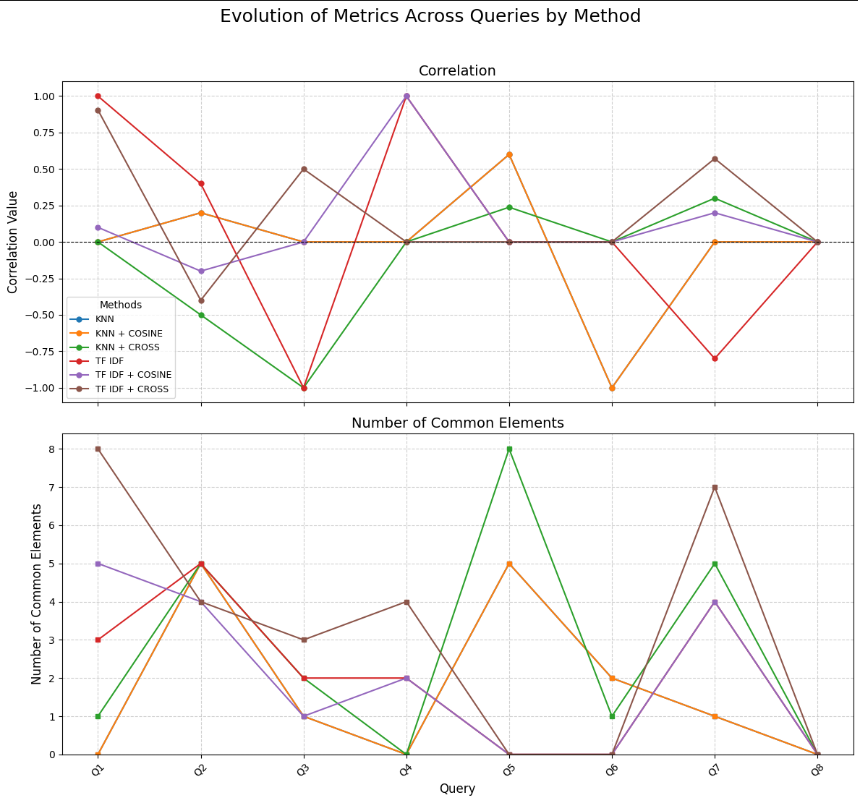